In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from itertools import product
import pandas as pd
import math
from tqdm import tqdm
%matplotlib inline 

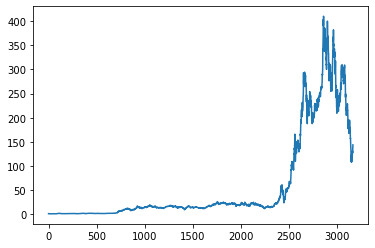

In [2]:
df = pd.read_csv('../TSLA.csv')
plt.plot(df['Adj Close'])
plt.show()

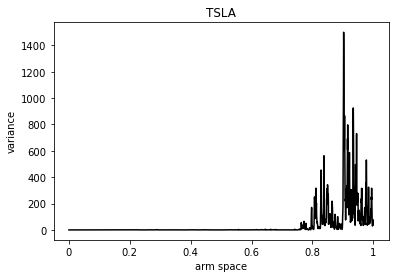

In [3]:
windows = 10
data = df['Adj Close'].rolling(windows).var()[windows-1:].values
plt.title('TSLA')
plt.xlabel('arm space')
plt.ylabel('variance')
ticks = [0, len(data)//5, len(data)*2//5, len(data)*3//5, len(data)*4//5, len(data)]
labels = [0, 0.2, 0.4, 0.6, 0.8, 1]
plt.xticks(ticks=ticks, labels=labels)
plt.plot(data, 'black')
plt.savefig('./TSLA.png', dpi=100)
plt.show()

In [4]:
def func(x):
    if x == 1:
        idx = -1
    else:
        idx = int(np.floor(x*(len(data)-1)))
    reward = data[idx]
    observation = np.random.normal(reward, 0.1)
    return reward, observation - reward

In [5]:
delta = 1e-2
MAX_REWARD = np.max(data)
delta_MAX = np.quantile(data, 1-delta)

In [6]:
class cube():
    
    def __init__(self, x1_left, x1_right, parent, children, xs, ys, bmo = True):
        self.x1_left = x1_left
        self.x1_right = x1_right
    
        self.parent = parent
        self.children = children
        
        self.xs = xs
        self.ys = ys
            
        self.bmo = False    
    
    def is_terminal(self):
        if len(self.children) == 0:
            return True
        else:
            return False
        
    def is_preparent(self):
        is_preparent = False
        for c in self.children:
            if c.is_terminal(): 
                return True
        
        return False
    
    def is_parent( self ):
        if self.parent is None:
            return True
        
        if self.parent.is_preparent():
            return False
        else:
            return True
        
    def measure(self): 
        return (self.x1_right - self.x1_left)
    
    def insert_point(self, x1, y): 
        if (x1 >= self.x1_left ) & (x1 <= self.x1_right ):           
            self.xs = list(self.xs) + [[x1]] 
            self.ys = list(self.ys) + [y] 
            
    def insert_all_children(self, x1, y):
        self.insert_point(x1, y) 
        for j in range(len(self.children)):
            q = self.children[j]
            q.insert_all_children(x1, y) 

    
        
    def get_terminals( self ):
        
        if len(self.children) == 0:
            return [self]                 
        l0 = self.children[0].get_terminals()
        l1 = self.children[1].get_terminals()
        
        return l0 + l1
    
    
    def get_all_cubes(self ):
        if len(self.children) == 0:
            return [self]                  
        l0 = self.children[0].get_terminals() 
        l1 = self.children[1].get_terminals() 
        return [self] + l0 + l1
        
        
    def m(self): 
        if len(self.ys):
            return np.mean(self.ys) 
        else:
            return 0

    def n(self):
        return len(self.ys)
    
    
    def get_parent(self):
        if self.parent is None:
            return self
        else:
            if self.parent.is_parent():
                return self.parent
            else:
                return self.parent.get_parent() 
            
    def reset_color(self):
        self.colored = False


In [7]:
def update_children(c, bmo = True, alpha=1):
    global split_times
    
    
    terminals = c.get_terminals() 

    updated = False

    for q in terminals: 

        if bmo :             
            condition = (np.log(T**2/epsilon) + np.log2(1/eta))/max([1,q.n()])  < alpha * np.log( q.measure() / eta )
        else:
            condition =  (np.log(T**2/epsilon) + np.log2(1/eta))/max([1,q.n()])  < (q.x1_right - q.x1_left) 

        if condition: 
            split_times += 1

            updated = True

            l_children = 0

            x1_mid = (q.x1_right + q.x1_left) / 2. 

            xs = np.array( q.xs ).copy(); ys = np.array( q.ys ).copy() 
            xs1 = xs[:,0].copy()
    
            xs_tmp = xs[ (xs1 < x1_mid), : ].copy()
            ys_tmp = ys[ (xs1 < x1_mid) ].copy()


            l_children += len(ys_tmp)

            q1 = cube( q.x1_left, x1_mid, 
                      q, [  ], xs_tmp, ys_tmp, bmo )

#                 x1_left, x1_right, x2_left, x2_right, parent, children, xs, ys, bmo = True

            xs = np.array( q.xs ).copy(); ys = np.array( q.ys ).copy() 
            xs1 = xs[:,0].copy()
            xs_tmp = xs[ (xs1 >= x1_mid), : ].copy()
            ys_tmp = ys[ (xs1 >= x1_mid)  ].copy()

            l_children += len(ys_tmp)

            q2 = cube( x1_mid, q.x1_right, 
                      q, [  ], xs_tmp, ys_tmp, bmo )

            q.children = [q1, q2] 

    return updated

In [8]:
N = 500; eta = 1e-5; T = 2 * N; alpha = 3;  epsilon = 1e-2

# bandit-bmo-z

In [9]:
arms = []; rewards = []; avg_rewards = []

for dummy in range(10):
    split_times = 0
    
    rewards_tmp = []; avg_rewards_tmp = []
    
    print(dummy)
    
    root = cube( 0, 1., None, [], [], [], True )

    for t in tqdm(range(N)): 

        terminals = root.get_terminals() 

        parents = []; Us = []; rs = []; ns = []; children_ns = []

        for q in terminals:
            p = q.get_parent()
            if p not in parents:
                parents.append(q.get_parent())

        for q in parents:
        
            u = q.m() +  (np.log(T**2/epsilon) + np.log2(1/eta))/max([1,q.n()]) +\
                       max([0, np.log( q.measure() / eta )  ] )

            Us.append( u ) 

            rs.append( q.x1_right - q.x1_left )
            ns.append( len(q.ys) ) 

            for i in range(len(q.children)):

                children_ns.append( len(q.children[i].ys) ) 

        selected = parents[ np.argmax( Us ) ]

        if len( selected.children ) == 0:

            x1 = np.random.uniform( selected.x1_left , selected.x1_right )

            reward, noise = func(x1) 

            root.insert_all_children( x1, reward + noise )

            updated = True 

            while updated:

                updated = update_children(root, alpha=alpha)

            arms.append((x1))

            rewards_tmp.append( reward ) 
            

        else:

            for j in range(2):

                x1 = np.random.uniform( selected.children[j].x1_left , selected.children[j].x1_right )

                reward, noise = func(x1) 

                root.insert_all_children( x1, reward + noise )

                updated = True

                while updated:
                    
                    updated = update_children(root, alpha=alpha)

                arms.append((x1))
                
                rewards_tmp.append( reward ) 


    rewards.append( rewards_tmp ) 
    

0


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 514.15it/s]


1


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 554.32it/s]


2


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 512.38it/s]


3


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 492.29it/s]


4


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 522.07it/s]


5


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 598.92it/s]


6


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 592.67it/s]


7


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 546.43it/s]


8


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 573.49it/s]


9


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 508.44it/s]


In [10]:
regrets_bmoz = []; delta_regrets_bmoz = []

for j in range(len(rewards)): 
    
    regret_tmp = []; delta_regret_tmp = []; 

    for i in range(len(rewards[j])):        
        regret = max([0, MAX_REWARD - rewards[j][i] ]) 
        delta_regret = max([0, delta_MAX - rewards[j][i] ])  
        
        regret_tmp.append(regret) 
        
        delta_regret_tmp.append( delta_regret )
        
    regrets_bmoz.append( regret_tmp ) 
    delta_regrets_bmoz.append( delta_regret_tmp )

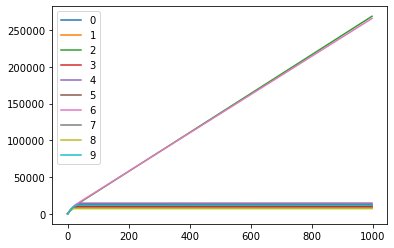

In [11]:
for i in range(10):
    data_delta = np.cumsum( delta_regrets_bmoz[i] )
    plt.plot( data_delta, label='{}'.format(i) ) 
plt.legend()
plt.show()

In [12]:
regrets_bmoz = []; delta_regrets_bmoz = []

for j in range(len(rewards)): 
    
    regret_tmp = []; delta_regret_tmp = []; 

    for i in range(len(rewards[j])):
        
        regret = max([0, MAX_REWARD - rewards[j][i] ]) 
        delta_regret = max([0, delta_MAX - rewards[j][i] ])  
        
        regret_tmp.append(regret) 
        
        delta_regret_tmp.append( delta_regret )
        
    regrets_bmoz.append( regret_tmp ) 
    delta_regrets_bmoz.append( delta_regret_tmp )

In [14]:
regret_m_delta = np.mean(np.cumsum(delta_regrets_bmoz, axis=1), axis=0)
regret_std_delta = np.std(np.cumsum(delta_regrets_bmoz, axis=1), axis=0)

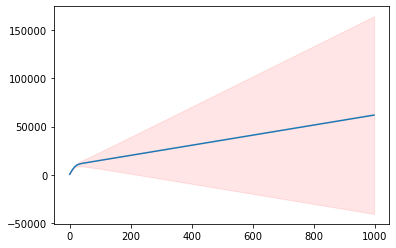

In [15]:
plt.plot(regret_m_delta)
plt.fill_between(np.array(range(len(regret_m_delta))), 
                                regret_m_delta - regret_std_delta, regret_m_delta + regret_std_delta, alpha=0.1, color='r')
plt.show()

In [16]:
np.savetxt('bmoz_delta.csv', delta_regrets_bmoz)
# np.savetxt('bmoz.csv', regrets_bmoz)

# bandit_bmo_p

In [17]:
from tqdm import tqdm

arms_p = []; rewards_p = []; avg_rewards_p = []; 

for dummy in range(10):
    
    split_times = 0
    
    print(dummy)
    
    rewards_tmp = []; avg_rewards_tmp = []
    
    root = cube( 0, 1., None, [], [], [], True )

    for t in tqdm(range(N*2)): 

        terminals = root.get_terminals() 

        Us = []; 

        for q in terminals:

            u = q.m() + (np.log(T**2/epsilon) + np.log2(1/eta))/max([1,q.n()]) +\
                       max([0, np.log( q.measure() / eta )  ] )

            Us.append( u ) 

        selected = terminals[ np.argmax( Us ) ]

        x1 = np.random.uniform( selected.x1_left , selected.x1_right )

        reward, noise = func(x1) 

        root.insert_all_children( x1, reward + noise )

        updated = True 

        while updated:
            updated = update_children(root) 

        arms.append((x1))
        
        rewards_tmp.append( reward )
    

    rewards_p.append( rewards_tmp ) 
    


0


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1352.64it/s]


1


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1323.26it/s]


2


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1088.04it/s]


3


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1323.33it/s]


4


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1284.08it/s]


5


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1395.67it/s]


6


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1279.95it/s]


7


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1164.81it/s]


8


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1174.70it/s]


9


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1387.95it/s]


In [18]:
regrets_bmop = []; delta_regrets_bmop = []

for j in range(len(rewards_p)): 
    
    regret_tmp = []; delta_regret_tmp = []; 

    for i in range(len(rewards_p[j])):
        
        regret = max([0, MAX_REWARD - rewards_p[j][i] ]) 
        delta_regret = max([0, delta_MAX - rewards_p[j][i] ])  
        
        regret_tmp.append(regret) 
        
        delta_regret_tmp.append( delta_regret )
        
    regrets_bmop.append( regret_tmp ) 
    delta_regrets_bmop.append( delta_regret_tmp )

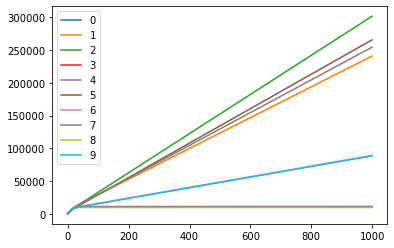

In [19]:
for i in range(10):
    data_delta = np.cumsum( delta_regrets_bmop[i] )
    plt.plot( data_delta, label='{}'.format(i) ) 
plt.legend()
plt.show()

In [20]:
regret_m_delta = np.mean(np.cumsum(delta_regrets_bmop, axis=1), axis=0)
regret_std_delta = np.std(np.cumsum(delta_regrets_bmop, axis=1), axis=0)

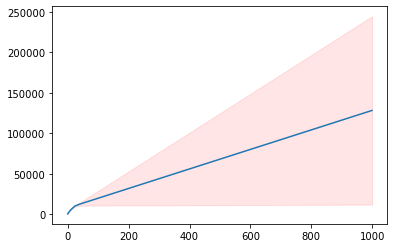

In [21]:
plt.plot(regret_m_delta)
plt.fill_between(np.array(range(len(regret_m_delta))), 
                                regret_m_delta - regret_std_delta, regret_m_delta + regret_std_delta, alpha=0.1, color='r')
plt.show()

In [22]:
np.savetxt('bmop_delta.csv', delta_regrets_bmop)
# np.savetxt('bmop.csv', regrets_bmop)